# Pour Hower 2018 Wet Run Analysis

### On September 14, 2018 Luke invited Emily, Emily, Lexa, Hilary, and Bennett over to listen to the 2018 power hour draft and give subjective ratings of each song along multiple dimensions. Below is an analysis of the data collected.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
import statsmodels.api as sm

/home/lukie/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lukie/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [3]:
#load data into single dataset
#create dataframe for each judge's csv
columns = ['song_num','transition_in','slap','surprise','sound_qual','sing_along','keep','transition_out']
drpizza = pd.read_csv('power_hour_analysis/drpizza.csv', names = columns, skiprows=1)
benny = pd.read_csv('power_hour_analysis/benny.csv', names = columns, skiprows=1)
hilary = pd.read_csv('power_hour_analysis/hilary.csv', names = columns, skiprows=1)
emmyk = pd.read_csv('power_hour_analysis/emmyk.csv', names = columns, skiprows=1)
lexa = pd.read_csv('power_hour_analysis/lexa.csv', names = columns, skiprows=1)
emads = pd.read_csv('power_hour_analysis/emads.csv', names = columns, skiprows=1)

#combine them into one dataframe
judges = [drpizza,benny,hilary,emmyk,lexa,emads]
df = pd.concat(judges)
df.head()

,song_num,transition_in,slap,surprise,sound_qual,sing_along,keep,transition_out
0,1.0,NaN,10.0,NaN,NaN,10.0,1.0,0.0
1,2.0,NaN,7.0,NaN,NaN,6.0,1.0,0.0
2,3.0,NaN,8.0,NaN,NaN,10.0,1.0,0.0
3,4.0,NaN,4.0,NaN,NaN,7.0,1.0,0.0
4,5.0,NaN,7.0,NaN,NaN,8.0,1.0,0.0


<b>Variable Descriptions:</b>

<b>song number:</b> position of the song in the 60-song power hour <br>
<b>transition in:</b> participant's subjective valence rating of the transition into this song from the last song<br>
<b>slap:</b> participant's subjective rating to answer the question "does this song fucking slap?" or "how hard does this song fucking slam?" or "how #hype does this song get me?"<br>
<b>surprise:</b> participant's subjective rating of how surprised they felt to hear the song come on. Most participants left this blank<br>
<b>sound quality:</b> participant's subjective rating of how good or bad the sound quality of the song felt<br>
<b>sing_along:</b> participant's subjective rating of how much they felt they could sing along to the song<br>
<b>keep:</b> binary variable (1=keep) signifying whether the participant thought the song should be kept in the power hour or killed (read:removed)<br>
<b>transition out:</b> same as transition in, but nobody filled this variable out

### Frequency of Keep/Kill Variable
We need to check to see if an overwhelming number of responses were kill because this could fuck up the estimate of our model intercept, which could in turn fuck up our predicted probabilities and compromise any predictions we want to make later.

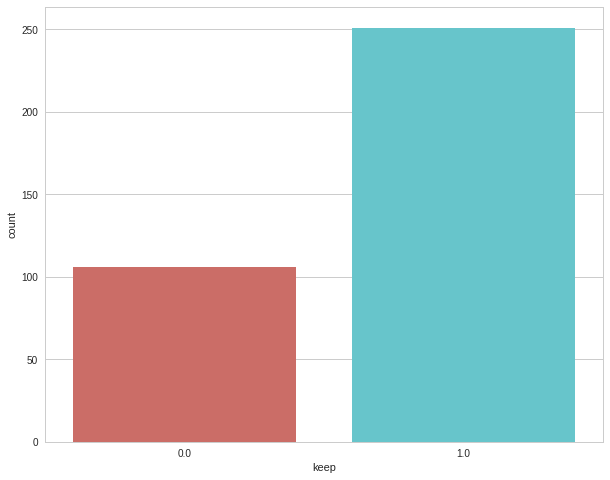

In [5]:
df['keep'].value_counts()
sb.countplot(x='keep',data=df, palette='hls')

In [6]:
df['keep'].value_counts()

1.0    251
0.0    106
Name: keep, dtype: int64

### Lol
so this is pretty unbalanced. We'll run as-is and then do a big funny correction later by creating synthetic kill examples and evening things up a bit. 

## Check for Missing Values
Spoiler: there are a ton

In [8]:
df.isnull().sum()

song_num            1
transition_in      78
slap                6
surprise          217
sound_qual        132
sing_along         19
keep                4
transition_out      1
dtype: int64

Nobody cared about transition in/out, surprise, or sound quality (most of the variables). So, do our values make any sense for slap and sing along?

In [9]:
df.groupby('keep').mean()

,song_num,transition_in,slap,surprise,sound_qual,sing_along,transition_out
keep,,,,,,,
0.0,30.509434,4.764706,3.980583,5.444444,7.360656,5.060000,5.132075
1.0,30.661355,6.670103,8.168675,6.797980,8.369048,8.413223,4.454183


It looks like ratings (1-10 Likert scale) for slap and sing_along (slap in particular) behave as expected. The mean ranking of how much a song fucking slaps was higher in the songs people wanted to keep.

### Let's just go ahead make this into a roughly hewn dataset without the empty variables

In [11]:
df = df[['keep','slap','sing_along','song_num']]
df.head()

,keep,slap,sing_along,song_num
0,1.0,10.0,10.0,1.0
1,1.0,7.0,6.0,2.0
2,1.0,8.0,10.0,3.0
3,1.0,4.0,7.0,4.0
4,1.0,7.0,8.0,5.0


#### Impute some missing values
We don't have many independent variables to work with here, so we're just gonna set missing values to the average value of that variable. This is a bad idea for a number of reasons not listed here.

In [13]:
#impute mean for missing slap and sing_along
df['slap'].fillna((df['slap'].mean()), inplace=True)
df['sing_along'].fillna((df['sing_along'].mean()), inplace=True)

In [14]:
df.isnull().sum()

keep          4
slap          0
sing_along    0
song_num      1
dtype: int64

In [15]:
# what is the deal with the row missing song_num?
df.loc[df['song_num'].isnull()==True]

,keep,slap,sing_along,song_num
60,NaN,6.949296,7.432749,NaN


In [16]:
#get rid of that shit, I don't know why it's missing.
df = df[df.song_num.notnull()]

In [17]:
df.loc[df['song_num'].isnull()==True]

,keep,slap,sing_along,song_num


### Let's Check out how horrendously our predictors are co-linear

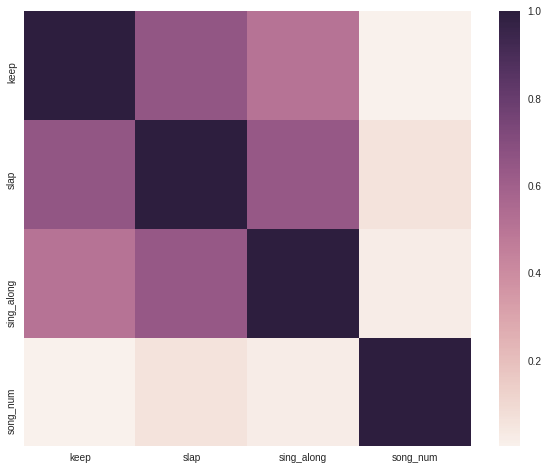

In [18]:
sb.heatmap(df.corr())

Slap and sing_along are pretty correlated, and song_num isn't correlated with anything (obviously)

In [19]:
#The rule of thumb for logistic regression is what? like 50 records per feature? We've got 'plenty'.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 59
Data columns (total 4 columns):
keep          357 non-null float64
slap          360 non-null float64
sing_along    360 non-null float64
song_num      360 non-null float64
dtypes: float64(4)
memory usage: 14.1 KB


## Fitting the Logistic Regression Model
We're going to fit the model 1.) with just slap 2.) with just sing_along and 3.) with both just for funsies. We'll then make some pretty dubious claims about the effect of these variables on the odds of a song being kept/killed. 

Then we'll use our model to decide the fate of the 3 songs that are missing the keep/kill outcome variable. Lol here we go.

In [20]:
#create training sets of all records that aren't missing keep/kill
x_train = df[['slap','sing_along','song_num']].loc[df['keep'].isnull() != True]
y_train = df['keep'].loc[df['keep'].isnull() != True]

#slap only
x_train_slap = df[['slap']].loc[df['keep'].isnull() != True]
#sing_along only
x_train_sa = df[['sing_along']].loc[df['keep'].isnull() != True]


#creating testing sets of 3 records that are missing keep/kill
x_test = df[['slap','sing_along','song_num']].loc[df['keep'].isnull() != False]
y_test = df['keep'].loc[df['keep'].isnull() != False]

#slap only
x_test_slap = df[['slap']].loc[df['keep'].isnull() != False]
#sing_along only
x_test_sa = df[['sing_along']].loc[df['keep'].isnull() != False]

#### Slap Only Model

In [21]:
logit_model=sm.Logit(y_train,x_train_slap)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.491767
         Iterations 5
                        Results: Logit
Model:              Logit            No. Iterations:   5.0000  
Dependent Variable: keep             Pseudo R-squared: 0.191   
Date:               2018-09-22 16:00 AIC:              353.1218
No. Observations:   357              BIC:              356.9995
Df Model:           0                Log-Likelihood:   -175.56 
Df Residuals:       356              LL-Null:          -217.14 
Converged:          1.0000           Scale:            1.0000  
-----------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
slap       0.1996     0.0197   10.1505   0.0000   0.1610   0.2381



#### Sing Along Only Model 

In [22]:
logit_model=sm.Logit(y_train,x_train_sa)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.532740
         Iterations 5
                        Results: Logit
Model:              Logit            No. Iterations:   5.0000  
Dependent Variable: keep             Pseudo R-squared: 0.124   
Date:               2018-09-22 16:01 AIC:              382.3762
No. Observations:   357              BIC:              386.2539
Df Model:           0                Log-Likelihood:   -190.19 
Df Residuals:       356              LL-Null:          -217.14 
Converged:          1.0000           Scale:            1.0000  
----------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
sing_along      0.1602    0.0169  9.4829  0.0000  0.1271  0.1934



#### Combined Model 

In [24]:
logit_model=sm.Logit(y_train,x_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.438342
         Iterations 6
                        Results: Logit
Model:              Logit            No. Iterations:   6.0000  
Dependent Variable: keep             Pseudo R-squared: 0.279   
Date:               2018-09-22 16:01 AIC:              318.9759
No. Observations:   357              BIC:              330.6091
Df Model:           2                Log-Likelihood:   -156.49 
Df Residuals:       354              LL-Null:          -217.14 
Converged:          1.0000           Scale:            1.0000  
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
slap         0.4596    0.0703   6.5357  0.0000   0.3218   0.5974
sing_along  -0.0666    0.0550  -1.2112  0.2258  -0.1744   0.0412
song_num    -0.0408    0.0078  -5.2398  0.0000  -0.0560  -0.0255



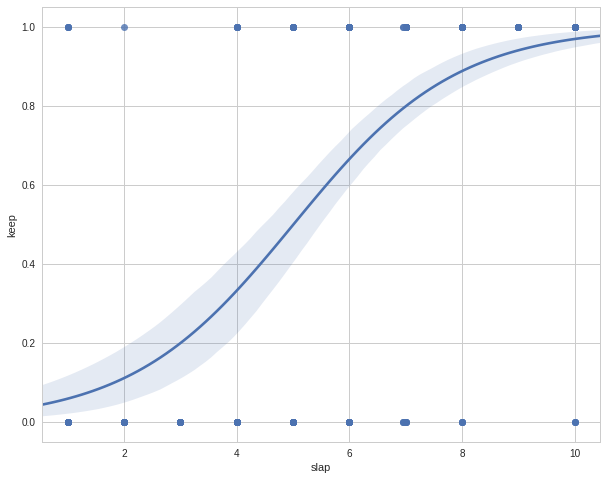

In [25]:
#seaborn gives easy and pretty graphics, so let's go ahead and show one, cuz that's what everybody wants
#out of a logistic regression anyway.
sb.regplot(x='slap', y='keep', data=df, logistic=True)

## Let's use our combined slap + sing_along model to decide the fates of the 3 songs that someone neglected to keep/kill 

In [36]:
#use our model to calculate the predicted probabilites of keep/kill for the 3 records that 
#came without a keep/kill rating
y_pred = result.predict(x_test)
y_pred

45    0.481637
0     0.958543
2     0.981627
dtype: float64

Note that the index shown here is 0-indexed, so these are actually songs 46, 1, and 3. Songs 1 and 3 are pretty clearly keepers. But what about song 46?

In [34]:
x_test.loc[x_test['song_num']==46]

,slap,sing_along,song_num
45,5.0,7.432749,46.0


So the person who forgot to decide whether or not to keep/kill this song also didn't rate it on sing_along, but gave it a slap score of 5. That's rough. Say goodbye to <b>Raise Your Glass</b> by <b>P!nk.</b> Jokes on you all though cuz I'm just gonna replace this with another P!nk song.

## The Culling 

In addition to This is America, we're going to take the bottom 10 rated songs, put them in a blender, eat them, and replace their spots in the power hour by 10 brand new songs. And I don't mean the rock band from Long Island, NY. But also, maybe I do.

We could just take the songs ranked with the lowest mean slappiness, but we already have this model, so let's take the songs with the lowest mean predicted keep probability, by running the model on the very data that made it!!! #WestWorld

In [39]:
x_murder = df[['slap','sing_along','song_num']]
y_murder = result.predict(x_murder)
x_murder['predicted_prob'] = y_murder

In [53]:
murder_means = x_murder[['song_num','predicted_prob']].groupby('song_num').mean()

In [55]:
murder_means.nsmallest(10, 'predicted_prob')

,predicted_prob
song_num,
53.0,0.299541
52.0,0.313324
27.0,0.317783
28.0,0.421666
57.0,0.525431
38.0,0.525721
24.0,0.581567
43.0,0.587261
45.0,0.601493


<b>Kill List:</b><br>
Song 53: <b>Graduation</b> by <b>Vitamin C</b><br>
Song 52: <b>Natural Woman</b> by <b>Aretha Franklin</b><br>
Song 27: <b>Truly, Madly, Deepy</b> by <b>Savage Garden</b><br>
Song 28: <b>Cruise (Remix ft. Nelly)</b> by <b>Florida Georgia line</b><br>
Song 57: <b>Defying Gravity</b> by <b>Idina Menzel and Kristin Chenoweth</b><br>
Song 38: <b>Back Here</b> by <b>BBMak</b><br>
Song 24: <b>You're Still the One</b> by <b>Shania Twain</b><br>
Song 43: <b>Sit Still, Look Pretty</b> by <b>Daya</b><br>
Song 45: <b>This is America</b> by <b>Childish Gambino</b><br>
Song 56: <b>Dirty Pop</b> by <b>NSYNC</b>